<font color=#4242f5>
        <h1><center><strong>CME466</strong></center></h1>
        <h1><center><strong>Design of an Advanced Digital System</strong></center></h1>
        <p><center><strong>Department of Electrical and Computer Engineering</strong></center></p>
        <p><center><strong>2024 Winter Term</strong></center></p>
</font>

<h1><font color = #f5bc42><strong>Don't be an online programmer</strong></font></h1>
<div style="text-align:center">
  <img src="../data/offlineProgrammer.jpg" alt="Fun Meme">
</div>


<h1> <font color=#ad42f5><strong>Module 2: Object Detection (OpenCV Edition)</strong></font></h1>

**Instructors:** 
- Dr. Khan Wahid (khan.wahid@usask.ca)
- Mokarrameh Einlou (mokarrameh.einlou@usask.ca)

Materials prepared by Mokarrameh Einlou (mokarrameh.einlou@usask.ca)

---

<h2><font color=#f542f2><strong>2.1. Image Recognition ( a.k.a Image Classification )</strong></font></h2>

An image recognition algorithm ( a.k.a an image classifier ) takes an image ( or a patch of an image ) as input and outputs what the image contains. In other words, the output is a class label ( e.g. “cat”, “dog”, “table” etc. ). How does an image recognition algorithm know the contents of an image ? Well, you have to train the algorithm to learn the differences between different classes. If you want to find cats in images, you need to train an image recognition algorithm with thousands of images of cats and thousands of images of backgrounds that do not contain cats. Needless to say, this algorithm can only understand objects / classes it has learned.

To simplify things, in this post we will focus only on two-class (binary) classifiers. You may think that this is a very limiting assumption, but keep in mind that many popular object detectors ( e.g. face detector and pedestrian detector ) have a binary classifier under the hood. E.g. inside a face detector is an image classifier that says whether a patch of an image is a face or background.

<h2><font color=#f542f2><strong>2.2. Anatomy of an Image Classifier</strong></font></h2>

The following diagram illustrates the steps involved in a traditional image classifier.

<div style="text-align:center">
  <img src="../data/hog_img/image-classification-pipeline-1024x372.jpg" alt="Image-Classification Pipelines">
    <figcaption></figcaption>
</div>

Interestingly, many traditional computer vision image classification algorithms follow this pipeline, while Deep Learning based algorithms bypass the feature extraction step completely. Let us look at these steps in more details.

<h2><font color=#f542f2><strong>2.3. Preprocessing</strong></font></h2>

Often an input image is pre-processed to normalize contrast and brightness effects. A very common preprocessing step is to subtract the mean of image intensities and divide by the standard deviation. Sometimes, gamma correction produces slightly better results. While dealing with color images, a color space transformation ( e.g. RGB to LAB color space ) may help get better results.

Notice that I am not prescribing what pre-processing steps are good. The reason is that nobody knows in advance which of these preprocessing steps will produce good results. You try a few different ones and some might give slightly better results. Here is a paragraph from Dalal and Triggs

“We evaluated several input pixel representations including grayscale, RGB and LAB colour spaces optionally with power law (gamma) equalization. These normalizations have only a modest effect on performance, perhaps because the subsequent descriptor normalization achieves similar results. We do use colour information when available. RGB and LAB colour spaces give comparable results, but restricting to grayscale reduces performance by 1.5% at 10−4 FPPW. Square root gamma compression of each colour channel improves performance at low FPPW (by 1% at 10−4 FPPW) but log compression is too strong and worsens it by 2% at 10−4 FPPW.”

As you can see, they did not know in advance what pre-processing to use. They made reasonable guesses and used trial and error.

As part of pre-processing, an input image or patch of an image is also cropped and resized to a fixed size. This is essential because the next step, feature extraction, is performed on a fixed sized image.

<h2><font color=#f542f2><strong>2.4. Feature Extraction</strong></font></h2>

The input image has too much extra information that is not necessary for classification. Therefore, the first step in image classification is to simplify the image by extracting the important information contained in the image and leaving out the rest. For example, if you want to find shirt and coat buttons in images, you will notice a significant variation in RGB pixel values. However, by running an edge detector on an image we can simplify the image. You can still easily discern the circular shape of the buttons in these edge images and so we can conclude that edge detection retains the essential information while throwing away non-essential information. The step is called feature extraction. In traditional computer vision approaches designing these features are crucial to the performance of the algorithm. Turns out we can do much better than simple edge detection and find features that are much more reliable. In our example of shirt and coat buttons, a good feature detector will not only capture the circular shape of the buttons but also information about how buttons are different from other circular objects like car tires.

Some well-known features used in computer vision are Haar-like features introduced by Viola and Jones, Histogram of Oriented Gradients ( HOG (https://learnopencv.com/histogram-of-oriented-gradients/)), Scale-Invariant Feature Transform ( SIFT ), Speeded Up Robust Feature ( SURF ) etc.

<h2><font color=#f542f2><strong>2.1. Using OpenCV and Cascade Classifiers (on images)</strong></font></h2>

<h3><font color=#4296f5><strong>2.1.1. Theory</strong></font></h3>

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001, linked [here](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf). It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

Here we will work with face detection. Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, Haar features shown in the below image are used. They are just like our convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle.

<div style="text-align:center">
    <img src="../data/haar_features.jpg" alt="Haar Features" />
</div>


Now, all possible sizes and locations of each kernel are used to calculate lots of features. (Just imagine how much computation it needs? Even a 24x24 window results over 160000 features). For each feature calculation, we need to find the sum of the pixels under white and black rectangles. To solve this, they introduced the integral image. However large your image, it reduces the calculations for a given pixel to an operation involving just four pixels. Nice, isn't it? It makes things super-fast.

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. The top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applied to cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features? It is achieved by Adaboost.
<br>
If you want to know more about Adaboost algorithm, click [here](https://mccormickml.com/2013/12/13/adaboost-tutorial/#:~:text=AdaBoost%20is%20a%20popular%20boosting,female%20based%20on%20their%20height.)

<div style="text-align:center">
    <img src="../data/haar.png" alt="Haar" />
</div>

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. Obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that most accurately classify the face and non-face images. (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then the same process is done. New error rates are calculated. Also new weights. The process is continued until the required accuracy or error rate is achieved or the required number of features are found).

The final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can't classify the image, but together with others forms a strong classifier. The paper says even 200 features provide detection with 95% accuracy. Their final setup had around 6000 features. (Imagine a reduction from 160000+ features to 6000 features. That is a big gain).

So now you take an image. Take each 24x24 window. Apply 6000 features to it. Check if it is face or not. Wow.. Isn't it a little inefficient and time consuming? Yes, it is. The authors have a good solution for that.

In an image, most of the image is non-face region. So it is a better idea to have a simple method to check if a window is not a face region. If it is not, discard it in a single shot, and don't process it again. Instead, focus on regions where there can be a face. This way, we spend more time checking possible face regions.

For this they introduced the concept of Cascade of Classifiers. Instead of applying all 6000 features on a window, the features are grouped into different stages of classifiers and applied one-by-one. (Normally the first few stages will contain very many fewer features). If a window fails the first stage, discard it. We don't consider the remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is that plan!

The authors' detector had 6000+ features with 38 stages with 1, 10, 25, 25 and 50 features in the first five stages. (The two features in the above image are actually obtained as the best two features from Adaboost). According to the authors, on average 10 features out of 6000+ are evaluated per sub-window.

So this is a simple intuitive explanation of how Viola-Jones face detection works. Read the paper for more details or check out the references in the Additional Resources section.

OpenCV provides a training method (see [Cascade Classifier Training](https://docs.opencv.org/3.4/dc/d88/tutorial_traincascade.html)) or pretrained models, that can be read using the cv::CascadeClassifier::load method. The pretrained models are located in the data folder in the OpenCV installation or can be found [here](https://github.com/opencv/opencv/tree/3.4/data).

The following code example will use pretrained Haar cascade models to detect faces and eyes in an image. First, a cv::CascadeClassifier is created and the necessary XML file is loaded using the cv::CascadeClassifier::load method. Afterwards, the detection is done using the cv::CascadeClassifier::detectMultiScale method, which returns boundary rectangles for the detected faces or eyes.

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('hPCTwxF0qf4', width=800, height=300)

<h3><font color=#4296f5><strong>2.1.2. Practical Implementation with OpenCV</strong></font></h3>

In [2]:
# Add the necessary libraries
import os
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
def display_img_plt(img):
    # load image using cv2....and do processing.
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    # as opencv loads in BGR format by default, we want to show it in RGB.

    plt.xticks([]), plt.yticks([])
    plt.show()

image shape: (331, 496, 3)


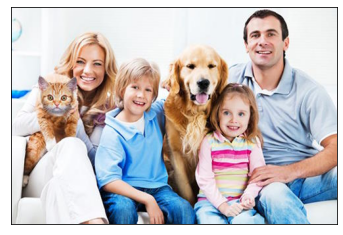

In [10]:
# Load the target image
image_path = os.path.join ('..', 'data', 'family.jpg')
img = cv.imread (image_path)
print (f"image shape: {img.shape}")

display_img_plt(img)

<div class="alert alert-info"><font color=black><strong>If you want to accelarate the detection process, you can resize the image.</strong></font></div>

In [5]:
# Resizing the image for people.jpg
#img = cv.resize (img, (800, 600))
#print (img.shape)


<div class="alert alert-info"><font color=black><strong>
You can also convert the image to gray scale to decrease the size again
    <br>
Actually this is recomended :)))
    </strong></font></div>

In [5]:
# 
face_cascade = cv.CascadeClassifier()
eyes_cascade = cv.CascadeClassifier()

In [6]:
# Using pretrained models
# Loading pretrained classifiers
if not face_cascade.load(cv.samples.findFile('../data/haarcascades/haarcascade_frontalface_alt.xml')):
    print('--(!)Error loading face cascade')
    exit(0)
if not eyes_cascade.load(cv.samples.findFile('../data/haarcascades/haarcascade_eye_tree_eyeglasses.xml')):
    print('--(!)Error loading eyes cascade')
    exit(0)

In [7]:
# Optimized for people.jpg
def detectAndDisplay(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)
    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray, scaleFactor = 1.0001, minNeighbors = 20, minSize = (200, 200), maxSize = (225, 225))
    
    
    print (faces)
    print (f"{len (faces)} faces are detected")
    
    
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = frame_gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI, scaleFactor = 1.01, minNeighbors = 10, minSize = (10, 10), maxSize = (50, 50))
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            frame = cv.circle(frame, eye_center, radius, (255, 0, 0 ), 4)
    display_img_plt(frame)

In [8]:
# Optimized for people3.jpg
def detectAndDisplay2(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)
    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray, scaleFactor = 1.001, minNeighbors = 12, minSize = (70, 70), maxSize = (500, 500))
    
    
    print (faces)
    print (f"{len (faces)} faces are detected")
    
    
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = frame_gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI, scaleFactor = 1.01, minNeighbors = 10, minSize = (10, 10), maxSize = (50, 50))
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            frame = cv.circle(frame, eye_center, radius, (255, 0, 0 ), 4)
    display_img_plt(frame)

[[302 134  76  76]
 [345  13  79  79]
 [ 82  57  73  73]
 [246  58  86  86]]
4 faces are detected


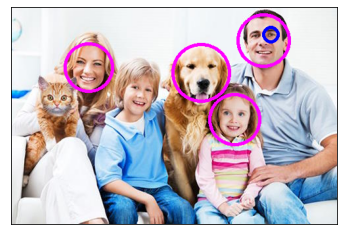

In [11]:
detectAndDisplay2(img)

cv.waitKey(0)
cv.destroyAllWindows()

<div class="alert alert-info"><font color=black>
<strong>What can we do to improve the results?</strong>
<br>
    
The face detection can be improved by adjusting the parameters:

- **scaleFactor:** Parameter specifying how much the image size is reduced at each image scale. A value of 1.05-1.20 is a good range to balance speed (higher numbers) and accuracy (lower numbers). Raising the value to 1.4+ may start to miss a face that is in between scaling sizes.
- **minNeighbors:** Required neighbors for each candidate rectangle. A higher value means fewer detections but with higher quality. A good range is 3-6.
- **minSize and maxSize:** Minimum and maximum face size in pixels. A good place to start is [30, 30] for the minSize. The default for maxSize is no upper limit.
    </font></div>

<h2><font color=#f542f2><strong>2.2. Using OpenCV and Cascade Classifiers (webcam)</strong></font></h2>

In [11]:
from __future__ import print_function
import cv2 as cv

def detectAndDisplay(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)
    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = frame_gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI)
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            frame = cv.circle(frame, eye_center, radius, (255, 0, 0 ), 4)
    cv.imshow('Capture - Face detection', frame)


face_cascade = cv.CascadeClassifier()
eyes_cascade = cv.CascadeClassifier()

#-- 1. Load the cascades
if not face_cascade.load(cv.samples.findFile("../data/haarcascades/haarcascade_frontalface_alt.xml")):
    print('--(!)Error loading face cascade')
    exit(0)
if not eyes_cascade.load(cv.samples.findFile("../data/haarcascades/haarcascade_eye_tree_eyeglasses.xml")):
    print('--(!)Error loading eyes cascade')
    exit(0)

#-- 2. Read the video stream
cap = cv.VideoCapture(0)
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay(frame)
    if cv.waitKey(10) == 27:
        break
cv.destroyAllWindows()

[ WARN:0@4.299] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


<h2><font color=#42f590><strong>2.3. Resources</strong></font></h2>

[Pretrained Models](https://github.com/opencv/opencv/tree/3.4/data/haarcascades)
<br>
[Cascade Classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)
<br>
[Haar Cascades, Explained](https://medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d)
<br>
[Cascade Classifier](https://apmonitor.com/pds/index.php/Main/CascadeClassifier)

<h1><font color = #f5bc42><strong>They can smell it ...</strong></font></h1>
<div style="text-align:center">
  <img src="../data/fear.jpeg" alt="Fun Meme"  width="400" height="500" >
</div>